0. Install and Import Dependencies

In [716]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio


In [717]:
tf.config.list_physical_devices('GPU')

[]

In [718]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

1. Build Data Loading Functions

In [719]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[ 310:370,300:435,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [720]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [721]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [722]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [723]:
char_to_num(['n','e','i','1'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  5,  9, 30])>

In [724]:
num_to_char([14,  5,  9, 30])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'e', b'i', b'1'], dtype=object)>

In [725]:
# from zipfile import ZipFile
# file_name = "./data_cantonese.zip"

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [726]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [727]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data_cantonese','s1',f'{file_name}.mp4')
    alignment_path = os.path.join('data_cantonese','alignment','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [728]:
test_path = './data_cantonese/s1/IMG_2834.mp4'

In [729]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'IMG_2834'

In [730]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'./data_cantonese/s1/IMG_2834.mp4'>

In [731]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [732]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(74, 60, 135, 1), dtype=float32, numpy=
 array([[[[ 0.59610504],
          [ 0.59610504],
          [ 0.54642963],
          ...,
          [ 0.7451313 ],
          [ 0.7451313 ],
          [ 0.6954559 ]],
 
         [[ 0.64578044],
          [ 0.64578044],
          [ 0.59610504],
          ...,
          [ 0.7451313 ],
          [ 0.7451313 ],
          [ 0.6954559 ]],
 
         [[ 0.6954559 ],
          [ 0.6954559 ],
          [ 0.6954559 ],
          ...,
          [ 0.6954559 ],
          [ 0.6954559 ],
          [ 0.6954559 ]],
 
         ...,
 
         [[ 1.1922101 ],
          [ 1.1922101 ],
          [ 1.1922101 ],
          ...,
          [12.617557  ],
          [12.6672325 ],
          [ 0.        ]],
 
         [[ 1.0431838 ],
          [ 1.0431838 ],
          [ 1.0928593 ],
          ...,
          [12.6672325 ],
          [12.6672325 ],
          [ 0.        ]],
 
         [[ 1.3909118 ],
          [ 1.2915609 ],
          [ 1.1922101 ],
          

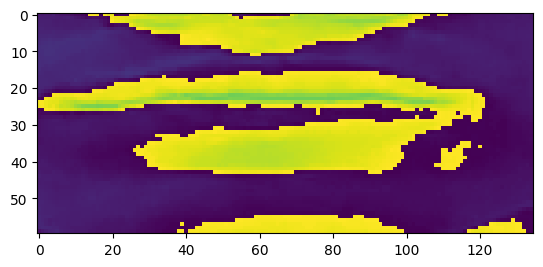

In [733]:
plt.imshow(frames[70])

In [734]:
alignments

<tf.Tensor: shape=(13,), dtype=int64, numpy=array([14,  7, 15, 34, 39, 15,  9, 32, 39, 14,  5,  9, 34])>

In [735]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'ngo5 oi3 nei5'>

In [736]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Create Data Pipeline

In [737]:
from matplotlib import pyplot as plt

In [738]:
data = tf.data.Dataset.list_files('./data_cantonese/s1/*.mp4')
data = data.shuffle(160, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[20]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
# Determine the sizes for training and testing sets
total_samples = 80
train_size = int(0.8 * total_samples)

# Split the data
train_data = data.take(train_size)
test_data = data.skip(train_size)

In [739]:
# for frames, target_sequence in data:
#     print("Target Sequence Length:", tf.shape(target_sequence)[1])


In [740]:
# for sample in data:  # Adjust the number of samples to print
#     video_frames, label = sample
#     # print(video_frames.shape)
#     if(video_frames.shape[1] > 75):
#         # print("No. of frames:", video_frames.shape[1])
#         print("Video Frames Shape:", video_frames.shape)
#         print("Label:", label.numpy())
#         print("~" * 50)

In [741]:
# # Assuming `data` is your dataset
# print("Element Spec:")
# print(data.element_spec)

# # Access the padded_shapes attribute for each element
# for element_spec in data.element_spec:
#     if isinstance(element_spec, tuple) and len(element_spec) == 2:
#         print("Padded Shape:", element_spec[1])


In [742]:
frames, alignments = data.as_numpy_iterator().next()

In [743]:
data.as_numpy_iterator().next()

(array([[[[[0.9218285 ],
           [0.8863735 ],
           [0.8509186 ],
           ...,
           [1.4181976 ],
           [1.5245625 ],
           [1.5245625 ]],
 
          [[0.8863735 ],
           [0.8863735 ],
           [0.81546366],
           ...,
           [1.4181976 ],
           [1.5245625 ],
           [1.5245625 ]],
 
          [[0.8509186 ],
           [0.81546366],
           [0.81546366],
           ...,
           [1.3472878 ],
           [1.4536526 ],
           [1.4536526 ]],
 
          ...,
 
          [[0.81546366],
           [0.78000873],
           [0.7090988 ],
           ...,
           [1.0281934 ],
           [1.0281934 ],
           [1.0281934 ]],
 
          [[0.8509186 ],
           [0.81546366],
           [0.81546366],
           ...,
           [1.0636482 ],
           [1.0991032 ],
           [1.0636482 ]],
 
          [[0.8863735 ],
           [0.8509186 ],
           [0.8509186 ],
           ...,
           [1.0636482 ],
           [1.0991032 

In [744]:
len(frames)

2

In [745]:
sample = data.as_numpy_iterator()

In [746]:
val = sample.next(); val[0]

array([[[[[ 0.66040444],
          [ 0.6132327 ],
          [ 0.6132327 ],
          ...,
          [11.8872795 ],
          [12.028795  ],
          [ 0.14151524]],

         [[ 0.66040444],
          [ 0.6132327 ],
          [ 0.6132327 ],
          ...,
          [12.028795  ],
          [ 0.04717175],
          [ 0.        ]],

         [[ 0.56606096],
          [ 0.56606096],
          [ 0.6132327 ],
          ...,
          [11.8872795 ],
          [11.934451  ],
          [ 0.        ]],

         ...,

         [[ 0.99060667],
          [ 0.99060667],
          [ 0.9434349 ],
          ...,
          [ 0.04717175],
          [ 0.04717175],
          [ 0.04717175]],

         [[ 0.99060667],
          [ 0.99060667],
          [ 0.99060667],
          ...,
          [ 0.09434349],
          [ 0.09434349],
          [ 0.09434349]],

         [[ 0.99060667],
          [ 0.99060667],
          [ 0.99060667],
          ...,
          [ 0.09434349],
          [ 0.09434349],
          

In [747]:
len(val[0])

2

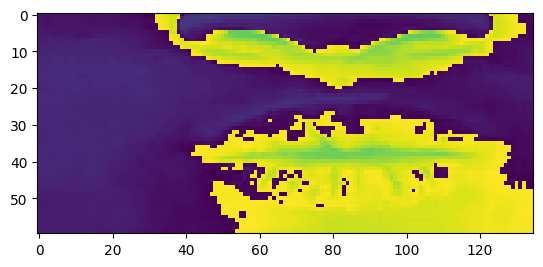

In [748]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][20])

In [749]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'waan4 dak1 hoi1'>

3.Design the Deep Neural Network

In [750]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [751]:
data.as_numpy_iterator().next()[0][0].shape

(75, 60, 135, 1)

In [752]:
def create_lip_reading_model(input_shape, num_classes):
    model = Sequential()
    
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))
    model.add(Conv3D(128, 3, input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))

    return model


In [753]:
input_shape = (75,60,135,1)  # Modify based on actual input shape
num_classes =  char_to_num.vocabulary_size()+1 # Replace with the actual number of classes

In [754]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [755]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [756]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset
        self.dataset_iterator = None
    
    def on_epoch_begin(self, epoch, logs=None) -> None:
        # Create a new iterator at the beginning of each epoch
        self.dataset_iterator = self.dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        # Get the next batch of data from the iterator
        data = self.dataset_iterator.next()

        # Make predictions using the trained model
        yhat = self.model.predict(data[0])

        # Decode the predicted sequences using CTC decoding
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

        total_samples = len(decoded)
        correct_predictions = 0

        for x in range(total_samples):
            original_str = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
            prediction_str = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')

            # Check if the prediction is correct
            if original_str == prediction_str:
                correct_predictions += 1

            print('Original:', original_str)
            print('Prediction:', prediction_str)
            print('~' * 100)

        accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1} Accuracy: {accuracy * 100:.2f}%')


In [757]:
from tensorflow.keras.models import load_model
custom_objects = {'CTCLoss': CTCLoss}
checkpoint_directory = './models/tested_model4'
# Ensure the checkpoint directory exists; if not, create it
os.makedirs(checkpoint_directory, exist_ok=True)
# Specify the checkpoint file path
checkpoint_path = os.path.join(checkpoint_directory, 'checkpoint')
# Check if there is a checkpoint file
if os.path.exists(checkpoint_path):
    print("Checkpoint exists in models.")
    # model = create_lip_reading_model(input_shape, num_classes)
    model = load_model(checkpoint_path,  custom_objects=custom_objects)
     # Retrieve the last epoch from the training history
    last_epoch = max(model.history.epoch) + 1 if hasattr(model.history, 'epoch') else 1
    # model.load_weights(checkpoint_path)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=CTCLoss)
else:
    # If there is no checkpoint, create a new model
    # input_shape = (100, 100, 720, 1)  # Modify based on your actual input shape
    # num_classes =  char_to_num.vocabulary_size()+1 # Replace with the actual number of classes
    model = create_lip_reading_model(input_shape, num_classes)
    print("No checkpoint found. Creating a new model.")


No checkpoint found. Creating a new model.


In [758]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 75, 60, 135, 128   3584      
                             )                                   
                                                                 
 activation_36 (Activation)  (None, 75, 60, 135, 128   0         
                             )                                   
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 75, 30, 67, 128)   0         
 ng3D)                                                           
                                                                 
 conv3d_37 (Conv3D)          (None, 75, 30, 67, 256)   884992    
                                                                 
 activation_37 (Activation)  (None, 75, 30, 67, 256)   0         
                                                     

In [759]:
# for batch in train_data:
#     x, y_true = batch
#     y_pred = model.predict(x)
#     print("Label shape:", y_true.shape)
#     print("Prediction shape:", y_pred.shape)


In [760]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [761]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'kssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss'>

In [762]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'kssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss'>

In [763]:
model.input_shape

(None, 75, 60, 135, 1)

In [764]:
model.output_shape

(None, 75, 41)

In [765]:
# from tensorflow.keras.utils import plot_model

# # Assuming 'model' is your neural network
# plot_model(model, to_file='model_network.png', show_shapes=True, show_layer_names=True)


4. Setup Training Options and Train

In [766]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss=CTCLoss )

In [767]:
# print("Number of sequences in the batch:", batch_len.numpy())

In [768]:
checkpoint_callback = ModelCheckpoint(
    os.path.join('model','tested_model4'),
    monitor='loss', 
    save_weights_only=False, 
    mode='min',
    save_best_only=True,) 

In [769]:
schedule_callback = LearningRateScheduler(scheduler)

In [770]:
example_callback = ProduceExample(test_data)

In [771]:
callbacks = [checkpoint_callback, schedule_callback, example_callback]

In [772]:
tf.keras.utils.get_custom_objects()['CTCLoss'] = CTCLoss


In [773]:
model.fit(train_data, validation_data=test_data, epochs=100, callbacks= callbacks)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 67.3667INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 2s 2s/step
Original: jau5 mou5 tai2 co3
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 man6 tai4
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 67.3667 - val_loss: 60.8670 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 56.0891INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: do1 ze6 saai3
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: fei1 soeng4 hou2
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 56.0891 - val_loss: 53.9522 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 50.6294INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: jat1 cai4 hang4
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 waan4 ge3
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3 Accuracy: 0.00%
64/64 [==============================] - 390s 6s/step - loss: 50.6294 - val_loss: 52.4014 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - ETA: 0s - loss: 47.7382INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: jau5 sik6 gwo3
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ping4 faai3 lok6
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 47.7382 - val_loss: 48.5029 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - ETA: 0s - loss: 46.6815INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: dak1 ji3 ge3
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 jau1 sik1
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 46.6815 - val_loss: 45.1756 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - ETA: 0s - loss: 46.0511INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: zoek3 faai3 lok6
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 dak1 hou2
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 6 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 46.0511 - val_loss: 45.5070 - lr: 1.0000e-04
Epoch 7/100
64/64 [==============================] - ETA: 0s - loss: 45.4728INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: zoek3 faai3 lok6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 noi6 mou5
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 7 Accuracy: 0.00%
64/64 [==============================] - 384s 6s/step - loss: 45.4728 - val_loss: 45.3087 - lr: 1.0000e-04
Epoch 8/100
64/64 [==============================] - ETA: 0s - loss: 44.9638INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: nei5 hou2 wan6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: oi3 cing4 tim4
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 8 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 44.9638 - val_loss: 46.6582 - lr: 1.0000e-04
Epoch 9/100
1/1 [==============================] - 1s 1s/step- loss: 45.07
Original: ping4 on1 hei2
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: siu2 sam1 di1
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 9 Accuracy: 0.00%
64/64 [==============================] - 374s 6s/step - loss: 45.0725 - val_loss: 43.9483 - lr: 1.0000e-04
Epoch 10/100
1/1 [==============================] 

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: jat1 cai4 hang4
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zan1 hai6 hou2
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 11 Accuracy: 0.00%
64/64 [==============================] - 385s 6s/step - loss: 44.2861 - val_loss: 47.3009 - lr: 1.0000e-04
Epoch 12/100
1/1 [==============================] - 1s 1s/step- loss: 44.45
Original: gam2 joeng2 waa3
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zoek3 hou2 wan6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 12 Accuracy: 0.00%
64/64 [==============================] - 376s 6s/step - loss: 44.4537 - val_loss: 44.1470 - lr: 1.0000e-04
Epoch 13/100
64/64 [======================

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: gam2 joeng2 waa3
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: fei1 soeng4 hou2
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 13 Accuracy: 0.00%
64/64 [==============================] - 382s 6s/step - loss: 43.7652 - val_loss: 43.0725 - lr: 1.0000e-04
Epoch 14/100
1/1 [==============================] - 1s 1s/step- loss: 43.90
Original: maan6 maan6 zau2
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hing1 fan5 aa3
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 14 Accuracy: 0.00%
64/64 [==============================] - 374s 6s/step - loss: 43.9079 - val_loss: 42.9061 - lr: 1.0000e-04
Epoch 15/100
64/64 [====================

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 hoi1 sam1
Prediction: h 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 jau1 sik1
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 15 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 43.2659 - val_loss: 45.6071 - lr: 1.0000e-04
Epoch 16/100
64/64 [==============================] - ETA: 0s - loss: 43.1431INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hoi1 sam1 di1
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: oi3 nei5 dei6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 16 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 43.1431 - val_loss: 42.9082 - lr: 1.0000e-04
Epoch 17/100
64/64 [==============================] - ETA: 0s - loss: 42.8511INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: seon6 lei6 di1
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 si4 gaan3
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 17 Accuracy: 0.00%
64/64 [==============================] - 383s 6s/step - loss: 42.8511 - val_loss: 43.9689 - lr: 1.0000e-04
Epoch 18/100
64/64 [==============================] - ETA: 0s - loss: 42.3647INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 hoi1 sam1
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 man6 tai4
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 18 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 42.3647 - val_loss: 40.7692 - lr: 1.0000e-04
Epoch 19/100
64/64 [==============================] - ETA: 0s - loss: 42.3266INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: faai3 di1 laa1
Prediction: a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 gam2 ze6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 19 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 42.3266 - val_loss: 41.5675 - lr: 1.0000e-04
Epoch 20/100
64/64 [==============================] - ETA: 0s - loss: 41.3196INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 hoi1 sam1
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 si4 gaan3
Prediction: ha 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 41.3196 - val_loss: 42.7750 - lr: 1.0000e-04
Epoch 21/100
64/64 [==============================] - ETA: 0s - loss: 41.0070INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: dang2 jat1 dang2
Prediction: ha a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ze6 ze6 nei5
Prediction: ha
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 21 Accuracy: 0.00%
64/64 [==============================] - 384s 6s/step - loss: 41.0070 - val_loss: 39.5664 - lr: 1.0000e-04
Epoch 22/100
64/64 [==============================] - ETA: 0s - loss: 40.7136INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: zan1 waa6 laa1
Prediction: a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 aa3
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 22 Accuracy: 0.00%
64/64 [==============================] - 384s 6s/step - loss: 40.7136 - val_loss: 40.1849 - lr: 1.0000e-04
Epoch 23/100
64/64 [==============================] - ETA: 0s - loss: 40.2435INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: m4 dang2 ngo5
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jat1 cai4 hang4
Prediction: a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 23 Accuracy: 0.00%
64/64 [==============================] - 384s 6s/step - loss: 40.2435 - val_loss: 40.8427 - lr: 1.0000e-04
Epoch 24/100
64/64 [==============================] - ETA: 0s - loss: 40.0013INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: jat1 cai4 hang4
Prediction: a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hing1 fan5 aa3
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 24 Accuracy: 0.00%
64/64 [==============================] - 384s 6s/step - loss: 40.0013 - val_loss: 38.2222 - lr: 1.0000e-04
Epoch 25/100
64/64 [==============================] - ETA: 0s - loss: 39.2978INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: waan2 dak1 hoi1
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: faai3 lok6 siu3
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25 Accuracy: 0.00%
64/64 [==============================] - 384s 6s/step - loss: 39.2978 - val_loss: 38.4213 - lr: 1.0000e-04
Epoch 26/100
64/64 [==============================] - ETA: 0s - loss: 38.4616INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: ze6 ze6 nei5
Prediction: he
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: waan4 dak1 hoi1
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 26 Accuracy: 0.00%
64/64 [==============================] - 382s 6s/step - loss: 38.4616 - val_loss: 36.4474 - lr: 1.0000e-04
Epoch 27/100
64/64 [==============================] - ETA: 0s - loss: 37.9516INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 geng1 aa3
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hoi1 sam1
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 27 Accuracy: 0.00%
64/64 [==============================] - 385s 6s/step - loss: 37.9516 - val_loss: 36.3677 - lr: 1.0000e-04
Epoch 28/100
64/64 [==============================] - ETA: 0s - loss: 36.7175INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: jau5 keoi3 di1
Prediction: a i
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: seon6 lei6 di1
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 28 Accuracy: 0.00%
64/64 [==============================] - 382s 6s/step - loss: 36.7175 - val_loss: 35.6125 - lr: 1.0000e-04
Epoch 29/100
64/64 [==============================] - ETA: 0s - loss: 36.3443INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hoi1 sam1 siu3
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 waan4 ge3
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 29 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 36.3443 - val_loss: 34.7277 - lr: 1.0000e-04
Epoch 30/100
64/64 [==============================] - ETA: 0s - loss: 35.6824INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: cing2 man6 laa1
Prediction: ho2 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 dak1 tai2
Prediction: ma 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30 Accuracy: 0.00%
64/64 [==============================] - 383s 6s/step - loss: 35.6824 - val_loss: 32.9954 - lr: 1.0000e-04
Epoch 31/100
64/64 [==============================] - ETA: 0s - loss: 34.5182INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: cai4 nou5 lik6
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 dak1 hou2
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 31 Accuracy: 0.00%
64/64 [==============================] - 385s 6s/step - loss: 34.5182 - val_loss: 32.3348 - lr: 9.0484e-05
Epoch 32/100
64/64 [==============================] - ETA: 0s - loss: 33.7394INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: m4 goi1 bong1 sau2
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 di1
Prediction: ho 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 32 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 33.7394 - val_loss: 30.7307 - lr: 8.1873e-05
Epoch 33/100
64/64 [==============================] - ETA: 0s - loss: 32.9119INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 hou2 teng1
Prediction: hou 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 man6 tai4
Prediction: ja ai
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 33 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 32.9119 - val_loss: 31.0941 - lr: 7.4082e-05
Epoch 34/100
64/64 [==============================] - ETA: 0s - loss: 31.6408INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: faai3 di1 laa1
Prediction: a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zan1 hai6 hou2
Prediction: ha o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 34 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 31.6408 - val_loss: 29.1983 - lr: 6.7032e-05
Epoch 35/100
64/64 [==============================] - ETA: 0s - loss: 31.0427INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: maan6 maan6 zau2
Prediction: a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zoek3 hou2 wan6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 35 Accuracy: 0.00%
64/64 [==============================] - 385s 6s/step - loss: 31.0427 - val_loss: 29.5684 - lr: 6.0653e-05
Epoch 36/100
64/64 [==============================] - ETA: 0s - loss: 29.7881INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: jat1 cai4 gaa1
Prediction: ja a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: soeng4 gam2 ze6
Prediction: hog g 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 36 Accuracy: 0.00%
64/64 [==============================] - 385s 6s/step - loss: 29.7881 - val_loss: 27.1717 - lr: 5.4881e-05
Epoch 37/100
64/64 [==============================] - ETA: 0s - loss: 29.5068INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: ceoi4 bin1 laa1
Prediction: hi a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hoi1 sam1
Prediction: hou h a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 37 Accuracy: 0.00%
64/64 [==============================] - 388s 6s/step - loss: 29.5068 - val_loss: 27.5606 - lr: 4.9659e-05
Epoch 38/100
64/64 [==============================] - ETA: 0s - loss: 28.6043INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: m4 goi1 man6
Prediction: m4 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ze6 bong1 mong6
Prediction: zo on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 38 Accuracy: 0.00%
64/64 [==============================] - 394s 6s/step - loss: 28.6043 - val_loss: 26.0806 - lr: 4.4933e-05
Epoch 39/100
64/64 [==============================] - ETA: 0s - loss: 28.5697INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: daai6 gaa1 hou2
Prediction: aho
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 dak1 ji3
Prediction: hou2 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 39 Accuracy: 0.00%
64/64 [==============================] - 397s 6s/step - loss: 28.5697 - val_loss: 26.4478 - lr: 4.0657e-05
Epoch 40/100
64/64 [==============================] - ETA: 0s - loss: 27.6905INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: fei1 soeng4 hou2
Prediction: zi o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 zan1 waa6
Prediction: oga1 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 40 Accuracy: 0.00%
64/64 [==============================] - 390s 6s/step - loss: 27.6905 - val_loss: 25.0211 - lr: 3.6788e-05
Epoch 41/100
64/64 [==============================] - ETA: 0s - loss: 27.2391INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hing1 fan5 aa3
Prediction: ha a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hoi1 sam1
Prediction: hou ho1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 41 Accuracy: 0.00%
64/64 [==============================] - 388s 6s/step - loss: 27.2391 - val_loss: 25.4778 - lr: 3.3287e-05
Epoch 42/100
64/64 [==============================] - ETA: 0s - loss: 26.2954INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hing1 fan5 aa3
Prediction: hon a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ze6 ze6 nei5
Prediction: ze
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 42 Accuracy: 0.00%
64/64 [==============================] - 389s 6s/step - loss: 26.2954 - val_loss: 24.5029 - lr: 3.0119e-05
Epoch 43/100
64/64 [==============================] - ETA: 0s - loss: 26.1590INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: dak1 ji3 ge3
Prediction: ma 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: mat1 je5 lei4
Prediction: ma1 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 43 Accuracy: 0.00%
64/64 [==============================] - 389s 6s/step - loss: 26.1590 - val_loss: 23.9323 - lr: 2.7253e-05
Epoch 44/100
64/64 [==============================] - ETA: 0s - loss: 25.9479INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: jat1 hei2 hang4
Prediction: a hi hg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: nei5 hou2 maa3
Prediction: hi a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 44 Accuracy: 0.00%
64/64 [==============================] - 388s 6s/step - loss: 25.9479 - val_loss: 23.8984 - lr: 2.4660e-05
Epoch 45/100
64/64 [==============================] - ETA: 0s - loss: 25.3797INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 leng3 zai2
Prediction: hou 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 dak1 tai2
Prediction: jau a1 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 45 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 25.3797 - val_loss: 24.3565 - lr: 2.2313e-05
Epoch 46/100
64/64 [==============================] - ETA: 0s - loss: 25.2948INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: zoek3 faai3 lok6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bong1 ngo5 gong2
Prediction: og g
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 46 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 25.2948 - val_loss: 22.0052 - lr: 2.0190e-05
Epoch 47/100
64/64 [==============================] - ETA: 0s - loss: 25.1422INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: jau5 mou5 tai2 co3
Prediction: ja5 ai 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: nei5 hou2 maa3
Prediction: he a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 47 Accuracy: 0.00%
64/64 [==============================] - 388s 6s/step - loss: 25.1422 - val_loss: 23.2386 - lr: 1.8268e-05
Epoch 48/100
64/64 [==============================] - ETA: 0s - loss: 24.9202INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: cai4 nou5 lik6
Prediction: ja 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 aa3
Prediction: hoi a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 48 Accuracy: 0.00%
64/64 [==============================] - 391s 6s/step - loss: 24.9202 - val_loss: 23.0362 - lr: 1.6530e-05
Epoch 49/100
64/64 [==============================] - ETA: 0s - loss: 24.6606INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 leng3 zai2
Prediction: hou a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gam2 joeng2 waa3
Prediction: ma ong a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 49 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 24.6606 - val_loss: 22.6516 - lr: 1.4957e-05
Epoch 50/100
64/64 [==============================] - ETA: 0s - loss: 24.1107INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 waan4 ge3
Prediction: ho2a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 si4 gaan3
Prediction: jau a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 24.1107 - val_loss: 22.9743 - lr: 1.3534e-05
Epoch 51/100
64/64 [==============================] - ETA: 0s - loss: 23.9648INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: mat1 je5 si6
Prediction: ma 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zan1 waa6 laa1
Prediction: an a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 51 Accuracy: 0.00%
64/64 [==============================] - 389s 6s/step - loss: 23.9648 - val_loss: 21.6456 - lr: 1.2246e-05
Epoch 52/100
64/64 [==============================] - ETA: 0s - loss: 23.7828INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 hoi1 sam1
Prediction: hou hoi a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hoi1 sam1
Prediction: hou2 ho1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 52 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 23.7828 - val_loss: 21.1803 - lr: 1.1080e-05
Epoch 53/100
1/1 [==============================] - 1s 1s/step- loss: 24.00
Original: bong1 m4 dou3
Prediction: mo 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: waan4 dak1 hoi1
Prediction: a ho
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 53 Accuracy: 0.00%
64/64 [==============================] - 380s 6s/step - loss: 24.0072 - val_loss: 22.3794 - lr: 1.0026e-05
Epoch 54/100
64/64 [==========

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 hou2 teng1
Prediction: hou2 hou 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: m4 dang2 ngo5
Prediction: m ang
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 54 Accuracy: 0.00%
64/64 [==============================] - 388s 6s/step - loss: 23.3115 - val_loss: 21.6225 - lr: 9.0718e-06
Epoch 55/100
1/1 [==============================] - 1s 1s/step- loss: 23.66
Original: ni1 dou6 hai6
Prediction: oi o a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zou2 tou2 aa3
Prediction: hou ou a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 55 Accuracy: 0.00%
64/64 [==============================] - 376s 6s/step - loss: 23.6677 - val_loss: 20.6340 - lr: 8.2085e-06
Epoch 56/100
1/1 [==========

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: nei5 hou2 wan6
Prediction: hi hou a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: seon6 lei6 di1
Prediction: on 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 59 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 23.1986 - val_loss: 20.4964 - lr: 5.5023e-06
Epoch 60/100
64/64 [==============================] - ETA: 0s - loss: 22.9410INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 hou2 teng1
Prediction: hou2 hou 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: soeng4 gam2 ze6
Prediction: hong ga 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 60 Accuracy: 0.00%
64/64 [==============================] - 388s 6s/step - loss: 22.9410 - val_loss: 20.9952 - lr: 4.9787e-06
Epoch 61/100
1/1 [==============================] - 1s 1s/step- loss: 23.11
Original: hoi1 sam1 ge3
Prediction: hoi 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hou2 teng1
Prediction: hou2 hou 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 61 Accuracy: 0.00%
64/64 [==============================] - 376s 6s/step - loss: 23.1127 - val_loss: 20.9181 - lr: 4.5049e-06
Epoch 62/100
1/1 [====

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: dak1 ji3 ge3
Prediction: a 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 siu3
Prediction: hoi1 a1 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 64 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 22.8027 - val_loss: 20.2082 - lr: 3.3373e-06
Epoch 65/100
64/64 [==============================] - ETA: 0s - loss: 22.7913INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: m4 haak3 hei3
Prediction: m ha h
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 sik6 gwo3
Prediction: jau o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 65 Accuracy: 0.00%
64/64 [==============================] - 385s 6s/step - loss: 22.7913 - val_loss: 20.7394 - lr: 3.0197e-06
Epoch 66/100
1/1 [==============================] - 1s 1s/step- loss: 22.83
Original: ping4 on1 lok6
Prediction: nin o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 waan4 ge3
Prediction: hou2a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 66 Accuracy: 0.00%
64/64 [==============================] - 378s 6s/step - loss: 22.8378 - val_loss: 20.6722 - lr: 2.7324e-06
Epoch 67/100
1/1 [===============

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: gong2 m4 ceot1
Prediction: hog o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: oi3 nei5 do1
Prediction: hoi o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 68 Accuracy: 0.00%
64/64 [==============================] - 386s 6s/step - loss: 22.7103 - val_loss: 21.3129 - lr: 2.2371e-06
Epoch 69/100
64/64 [==============================] - ETA: 0s - loss: 22.5582INFO:tensorflow:Assets written to: model/tested_model4/assets


INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: zaan6 hou2 do1
Prediction: ha ou 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 jau1 sik1
Prediction: hou2 a1 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 69 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 22.5582 - val_loss: 20.1993 - lr: 2.0242e-06
Epoch 70/100
1/1 [==============================] - 1s 1s/step- loss: 22.85
Original: sing4 jat6 gam2
Prediction: jn a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 di1
Prediction: ho a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 70 Accuracy: 0.00%
64/64 [==============================] - 376s 6s/step - loss: 22.8556 - val_loss: 18.8045 - lr: 1.8316e-06
Epoch 71/100
1/1 [=============

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: gam2 joeng2 waa3
Prediction: ma ong a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bong1 m4 dou3
Prediction: og u
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 74 Accuracy: 0.00%
64/64 [==============================] - 389s 6s/step - loss: 22.3552 - val_loss: 19.9460 - lr: 1.2277e-06
Epoch 75/100
1/1 [==============================] - 1s 1s/step- loss: 22.40
Original: oi3 cing4 tim4
Prediction: oi 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zan1 waa6 laa1
Prediction: an a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 75 Accuracy: 0.00%
64/64 [==============================] - 377s 6s/step - loss: 22.4064 - val_loss: 20.2466 - lr: 1.1109e-06
Epoch 76/100
1/1 [================

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: zoi3 gin3 laa1
Prediction: hoi g a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hou2 teng1
Prediction: hou ou n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 78 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 22.3485 - val_loss: 20.9185 - lr: 8.2298e-07
Epoch 79/100
1/1 [==============================] - 1s 1s/step- loss: 22.68
Original: hing1 fan5 aa3
Prediction: hi a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: tai2 haa5 laa1
Prediction: ai a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 79 Accuracy: 0.00%
64/64 [==============================] - 382s 6s/step - loss: 22.6820 - val_loss: 19.7492 - lr: 7.4466e-07
Epoch 80/100
1/1 [============

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: oi3 nei5 dei6
Prediction: oi 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sing4 jat6 gam2
Prediction: jn a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 87 Accuracy: 0.00%
64/64 [==============================] - 387s 6s/step - loss: 22.3337 - val_loss: 20.1575 - lr: 3.3460e-07
Epoch 88/100
1/1 [==============================] - 1s 1s/step- loss: 22.50
Original: hou2 noi6 mou5
Prediction: hou2 ou
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: nei5 hou2 maa3
Prediction: ei a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 88 Accuracy: 0.00%
64/64 [==============================] - 373s 6s/step - loss: 22.5073 - val_loss: 19.4407 - lr: 3.0276e-07
Epoch 89/100
1/1 [==================

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 jau1 sik1
Prediction: hou2 a1 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: nei5 hou2 maa3
Prediction: ei a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 90 Accuracy: 0.00%
64/64 [==============================] - 381s 6s/step - loss: 22.2979 - val_loss: 20.5979 - lr: 2.4788e-07
Epoch 91/100
1/1 [==============================] - 1s 1s/step- loss: 22.52
Original: gam2 joeng2 waa3
Prediction: ma ong a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: oi3 nei5 do1
Prediction: hoi o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 91 Accuracy: 0.00%
64/64 [==============================] - 371s 6s/step - loss: 22.5260 - val_loss: 19.9363 - lr: 2.2429e-07
Epoch 92/100
64/64 [=========

INFO:tensorflow:Assets written to: model/tested_model4/assets


1/1 [==============================] - 1s 1s/step
Original: m4 dang2 ngo5
Prediction: m ang
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jat1 nou5 lik6
Prediction: ja o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 92 Accuracy: 0.00%
64/64 [==============================] - 377s 6s/step - loss: 22.0860 - val_loss: 19.6679 - lr: 2.0294e-07
Epoch 93/100
1/1 [==============================] - 1s 1s/step- loss: 22.58
Original: hou2 dak1 ji3
Prediction: hou2 da 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: m4 dou3 sau2
Prediction: m u
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 93 Accuracy: 0.00%
64/64 [==============================] - 372s 6s/step - loss: 22.5885 - val_loss: 20.6668 - lr: 1.8363e-07
Epoch 94/100
1/1 [===================

In [774]:
loaded_model = tf.keras.models.load_model('model/tested_model4')

In [785]:
test = test_data.as_numpy_iterator()

In [786]:
sample = test.next()

In [787]:
yhat = loaded_model.predict(sample[0])

1/1 [==============================] - 1s 1s/step


In [788]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'jau5 dak1 tai2'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'mou5 co3 laa1'>]

In [789]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [790]:
print('~'*100, 'PREDICTION')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTION


[<tf.Tensor: shape=(), dtype=string, numpy=b'jaa '>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'mo'>]

In [791]:
model.save("model_4.h5")

/home/dennislaw/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [792]:
load_saved_model = tf.keras.models.load_model("model_4.h5")
load_saved_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 75, 60, 135, 128   3584      
                             )                                   
                                                                 
 activation_36 (Activation)  (None, 75, 60, 135, 128   0         
                             )                                   
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 75, 30, 67, 128)   0         
 ng3D)                                                           
                                                                 
 conv3d_37 (Conv3D)          (None, 75, 30, 67, 256)   884992    
                                                                 
 activation_37 (Activation)  (None, 75, 30, 67, 256)   0         
                                                     

In [783]:
import pandas as pd
metrics_df = pd.DataFrame(load_saved_model.history)

In [784]:
metrics_df

""
